<a href="https://colab.research.google.com/github/Aritro30/CPSC-533R-Visual-AI-Assignment-3/blob/main/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Neural Rendering and Shape Processing
## CPSC 533R Visual AI
### by Helge Rhodin

This assignment is on neural rendering and shape processing---computer graphics. We provide you with a dataset of 2D icons and corresponding vector graphics as shown in the figure below. It stems from a line of work on translating low-resolution icons to visually appealing vector forms and was kindly provided by Sheffer et al. [[1]](http://www.cs.ubc.ca/labs/imager/tr/2018/PerceptionDrivenVectorization/) for the purpose of this assignment.

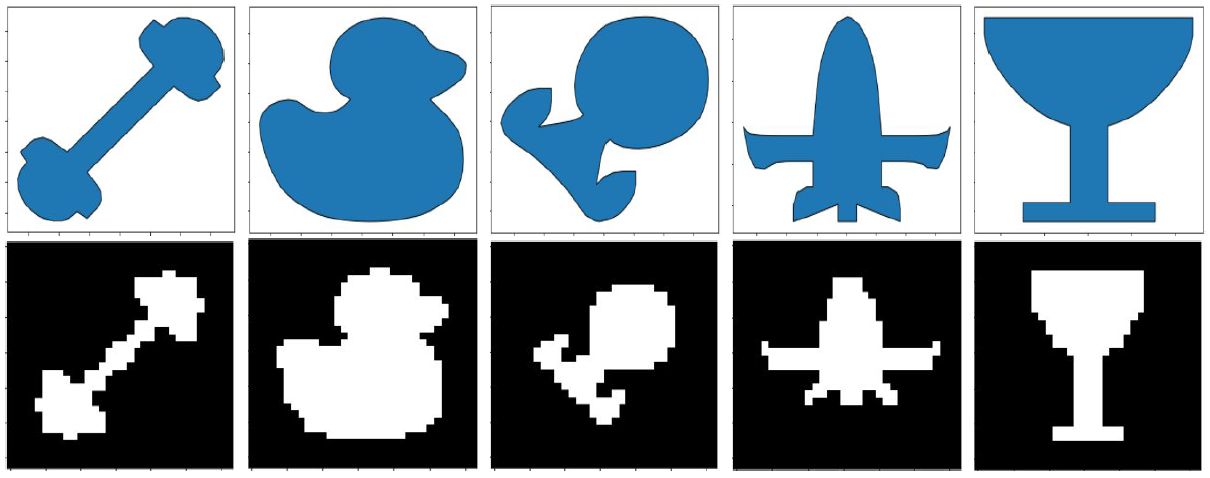

[[1] Hoshyari et al., Perception-driven semi-structured boundary vectorization. TOG 2018](http://www.cs.ubc.ca/labs/imager/tr/2018/PerceptionDrivenVectorization/)


# Setting up the environment

The overall goal of this assignment is to find transformation between icons. We provide the `ImagerIcon` dataset as an HDF5 file and dataloading functionality, with training and validation splits, as well as display and training functionality. 

Images are 32 x 32 icon bitmaps stored as $1 \times W \times H$ tensors. 
Vector graphics are represented as polygons with $N=96$ vertices and are stored as $2 \times N$ tensors, with neighboring points stored sequentially. 

Inspect the following functions before proceeding with Task I.

In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# import plotting utilities
import matplotlib.pyplot as plt
from IPython import display

# define constants
import math # needed for math.pi
eps = 0.00001
device = "cuda"

In [2]:
# download dataset from the web (200 KB file from https://www.cs.ubc.ca/~rhodin/20_CPSC_532R_533R/assignments/ImagerIcon_subset.hdf5)
dataset_file_name = "ImagerIcon_subset.hdf5"
import os.path
import urllib
if not os.path.exists(dataset_file_name):
    print("Downloading dataset")
    urllib.request.urlretrieve("https://www.cs.ubc.ca/~rhodin/20_CPSC_532R_533R/assignments/"+dataset_file_name, dataset_file_name)
    print("Done downloading")
else:
    print("Dataset already present, nothing to be done")

Done downloading


In [3]:
# loading of icon images and vectors
import h5py
import os

# loading of the icon dataset 
class IconDataset(torch.utils.data.Dataset):
    def __init__(self, data_file):
        super(IconDataset).__init__()
        print("Loading dataset to memory, can take some seconds")
        with h5py.File(data_file, 'r') as hf:
            self.polygon = torch.from_numpy(hf['polygon'][...])
            self.imgs  = torch.from_numpy(hf['img'][...])[:,:1,:,:]
        print(".. done loading")
        
    def __len__(self):
        return self.polygon.shape[0]
    
    def __getitem__(self, idx):
        # transpose to bring the point dimension in the first place
        poly = self.polygon[idx].T.clone()
        # negate show icons upright, scale to make networks better behaved
        poly[1,:] *= -1
        sample = {'img': self.imgs[idx].float()/255, # shape 1 x H x W
                  'polygon': poly, # shape 2 x N
                  }
        return sample

In [4]:
# load and split the dataset
icon = IconDataset(dataset_file_name)
print("Number of examples in dataset: {}".format(len(icon)))

val_ratio = 0.05
val_size = int(len(icon)*val_ratio)
indices_val = list(range(0, val_size))
indices_train = list(range(val_size, len(icon)))

val_set = torch.utils.data.Subset(icon, indices_val)
train_set = torch.utils.data.Subset(icon, indices_train)

Loading dataset to memory, can take some seconds
.. done loading
Number of examples in dataset: 44


torch.Size([2, 96])


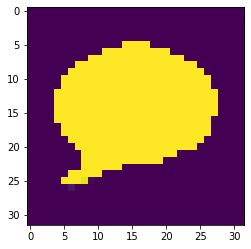

torch.Size([2, 96])


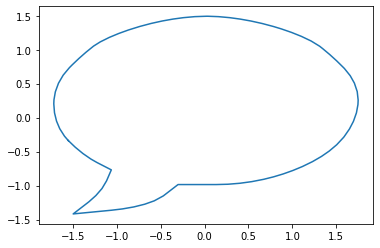

96


In [5]:
# display dataset examples
i = 2
print(train_set[i]['polygon'].shape)
img_pil = torchvision.transforms.ToPILImage()(train_set[i]['img'])
plt.imshow(img_pil)
plt.show()
print((train_set[i]['polygon'].shape))
plt.plot(*train_set[i]['polygon'])
plt.show()
num_points = train_set[i]['polygon'].shape[-1]
print(num_points)

In [6]:
# a helper function to map between devices (GPU and CPU)
def dict_to_device(dict_in, device):
    dict_out = {}
    for k,v in dict_in.items():
        dict_out[k] = v.to(device)
    return dict_out

# Task I: Neural Rendering

Implement a neural network that takes a batch of vector images as input and outputs corresponding bitmap images, i.e., that can map the top row of the teaser figure to the bottom row. This is an instance of neural rendering via supervised learning. The core of your task is to implement a neural network that uses transposed convolution (aka. deconvolution) with stride 2 or more. On top, you can use any other neural network layers, such as `ReLU`, `linear`, `batch norm`, `max pooling`, and `bilinear interpolation` operations. Chose a suitable loss function as the criterion.

In [7]:
# network architecture skeleton
class IconGenerator(nn.Module):
    def __init__(self, num_points, channels=32, out_channels=1):
        super(IconGenerator, self).__init__()

        # maps the input points of size (batch dim) x 2 x N
        # to a feature map (batch dim) x (#channels) x 2 x 2 
        self.MLP = nn.Sequential(
            nn.Linear(in_features=num_points*2, out_features=channels * 2*2),
            nn.ReLU(True),
        )

        # define a sequence of upsampling, batch norm, ReLu, etc. to map 2x2 features to 32 x 32 images
        self.main = nn.Sequential(
            # input size: (batch dim) x (#channels) x 2 x 2

            # TODO, TASK I: define a sequence of suitable layers. Note, you don't have to use nn.Sequential.
            nn.ConvTranspose2d(in_channels = channels, out_channels = out_channels, kernel_size = 4, stride = 2),
            nn.BatchNorm2d(out_channels),
            nn.ConvTranspose2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 4, stride = 2),
            nn.BatchNorm2d(out_channels),
            nn.ConvTranspose2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 6, stride = 2),
            nn.Sigmoid(),
            # output size: (batch dim) x (#out_channels=1) x 32 x 32
        )
      

    def forward(self, input_dict):
        poly = input_dict['polygon']
        batch_size = poly.shape[0]
        img_init = self.MLP(poly.view([batch_size,-1]))
        img = self.main(img_init.view([batch_size,-1,2,2]))
        return {'img': img}
network_gen = IconGenerator(num_points).cuda()

In [8]:
# helper function for plotting. It will be used for all subsequent tasks. You should not need to touch this
def display_io(axes, preds, labels, losses, epoch):
    # render the first image in the batch after each epoch
    for ax in axes:
        ax.cla()
    bi = 0 #epoch % batch_size
    axi = 0

    points_gt = labels['polygon'][bi].cpu()
    axes[axi].fill(*points_gt, edgecolor='k', fill=True) # this command closes the loop
    axes[axi].plot(*points_gt.cpu()[:,0],'.',ms=10,color='red') # mark the first vertext to identify issue
    #axes[axi].plot(*points_gt.cpu(),'.') # this command closes the loop
    axes[axi].set_title('Input polygon')
    axi +=1

    if 'img' in preds:
        p_img_pil = torchvision.transforms.ToPILImage()(preds['img'][bi].cpu())
        axes[axi].imshow(p_img_pil)
        axes[axi].set_title('Rendered image')
        axi +=1

        l_img_pil = torchvision.transforms.ToPILImage()(labels['img'][bi].cpu())
        axes[axi].imshow(l_img_pil)
        axes[axi].set_title('Ground truth image')
        axi +=1

    if 'polygon' in preds:
        axes[axi].plot(*preds['polygon'][bi].detach().cpu()[:,0],'.',ms=10,color='red') # mark the first vertext to identify issue
        axes[axi].fill(*preds['polygon'][bi].detach().cpu(), edgecolor='k', fill=True) # this command closes the loop
        axes[axi].set_title('Output polygon')
        axi += 1

        axes[axi].fill(*points_gt.cpu(), edgecolor='gray', fill=False) # this command closes the loop
        axes[axi].plot(*preds['polygon'][bi].detach().cpu(),".")
        axes[axi].set_title('Output pointcloud (GT in gray)')
        axi += 1

    axes[axi].plot(losses)
    axes[axi].set_yscale('log')
    axes[axi].set_title('Training loss')
    axes[axi].set_xlabel("Gradient iterations")

    display.clear_output(wait=True)
    display.display(plt.gcf())
    print("Plot after epoch {} (iteration {})".format(epoch, len(losses)))  

In [9]:
# functions to change the starting point of a polygon, used for later tasks
def roll_dim2(x, n=1):
    return torch.cat((x[:,:,-n:], x[:,:,:-n]),dim=2)

def augment_polygon(poly):
    # shift starting point
    num_points = poly.shape[-1]
    random_number = torch.LongTensor(1).random_(0, num_points).item()
    poly = roll_dim2(poly,n=random_number)
    return poly

# main training loop, will be used throughout this assignment
def train(train_loader, network, loss_fn, num_training_epochs, key="img", augmentation=False):
    losses = []
    
    fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
    axes=fig.subplots(1,4)
    optimizer = optim.Adam(network.parameters(), lr=0.001)
    for epoch in range(num_training_epochs):
        iterator = iter(train_loader)
        network.train()
        for i in range(len(train_loader)):
            batch_cpu = next(iterator)
            batch_size = batch_cpu[key].shape[0]
            if augmentation:
                batch_cpu['polygon'] = augment_polygon(batch_cpu['polygon'])

            batch = dict_to_device(batch_cpu, device)

            preds = network(batch)
            
            loss = loss_fn(preds[key], batch[key])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if epoch % max(num_training_epochs//1000,1) == 0:
          display_io(axes, preds, batch, losses, epoch)
    display.clear_output(wait=True)

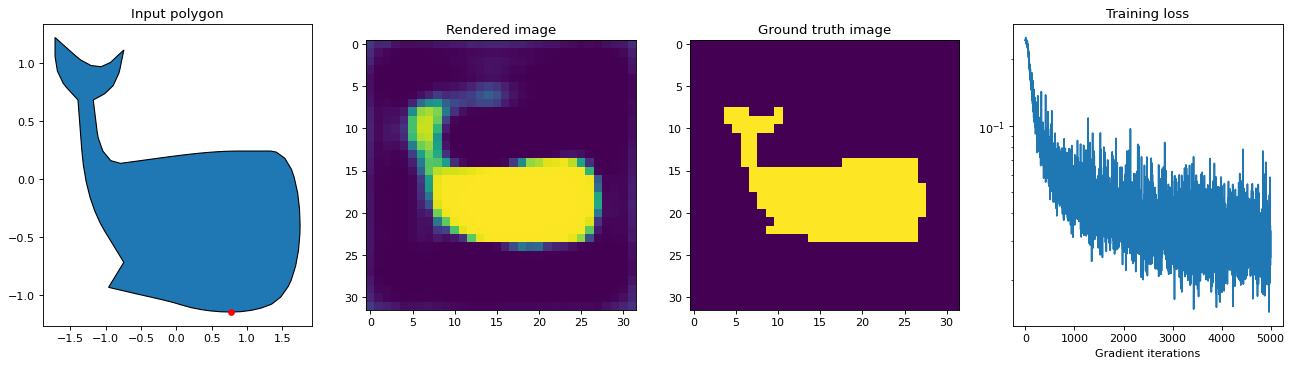

In [10]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 4, shuffle=True, drop_last=True)
#loss_fn = # TODO loss function
loss_fn = torch.nn.MSELoss()
train(train_loader, network_gen, loss_fn, num_training_epochs=500)

# Task II: Training a simple auto encoder

Train the provided simple autoencoder (AE). Inspect the red dot in the output, which indicates the starting point of the polygon. Note, although the polygon is drawn as a closed loop, we have to store it as a sequence with start and end. Application of the MSE loss compares the positions of the polygon vertices in the order they are stored in memory. However, the start changes arbitrarily for each of the vector icons and is difficult to predict for the network. The Chamfer distance is designed to handle such mismatch via nearest neighbor comparisons. Implement the `chamfer_distance` function to train the AE a second time and explain why it is not working as desired. 

**Hints.** 
 * The provided dataset is relatively small scale. One epoch contains only a handful of images. You will have to run many epochs. Training deeper neural networks takes a while. Don't draw conclusions too early. Particularly your network from Task IV may take 1000 or 2000 iterations to show reasonable results. See the following plot for a training example from Task IV. 
 * Due to the small dataset, you have to focus on a compact architecture with relatively few parameters to avoid overfitting. Note that this is not an unusual setting. For instance, it is a recent trend to train GANs on a single image, e.g., [SinGAN](https://github.com/RobinSeaside/SinGAN-1). Nevertheless, we do not expect your networks to generalize that well to the validation set. It is rather a simplified development example to enable relatively quick training within the scope of this assignment.

 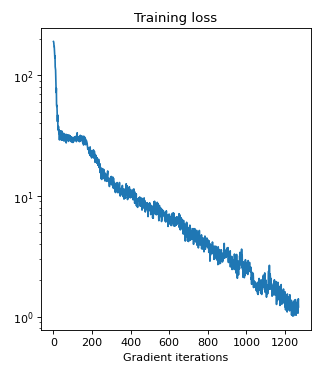

In [11]:
# simple (but inefficient) polygon autoencoder using fully-connected layers
class AE(nn.Module):
    def __init__(self, num_points, bottleneck_width):
        super(AE, self).__init__()
        max_channels = 128
        
        self.fc1a = nn.Linear(2*num_points, max_channels)
        self.fc1c = nn.Linear(max_channels, bottleneck_width)
        
        self.fc2a = nn.Linear(bottleneck_width, max_channels)
        self.fc2c = nn.Linear(max_channels, 2*num_points)

    def encode(self, dictionary):
        x = dictionary['polygon']
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h1 = nn.ReLU()(self.fc1a(x))
        return self.fc1c(h1)
    
    def decode(self, z):
        batch_size = z.shape[0]
        h2 = nn.ReLU()(self.fc2a(z))
        h2 = self.fc2c(h2)
        
        y_NCW = h2.view([batch_size,2,-1])
        return {'polygon': y_NCW}

    def forward(self, dictionary):
        z = self.encode(dictionary)        
        poly_dict = self.decode(z)
        return poly_dict

In [12]:
# two-sided loss on the distance of every point to its nearest neighbor
def chamfer_distance(pred, label):
    B, D, K = pred.shape
    pred  = pred.permute(2,1,0)
    label  = label.permute(2,1,0)
    pred_repeat = torch.tile(pred, (K, 1, 1))
    label_repeat = torch.tile(label, (K, 1, 1))
    min_label = 0
    min_pred = 0 
    loss = torch.zeros(1, requires_grad=True)  
    l = []
    for i in range(K):
      start = i*K
      end = start+K
      min_pred+=(torch.min(torch.sum((torch.tile(pred[i],(K,1)).view(K, D, B) - label_repeat[start:end,:,:])**2, dim = 1).unsqueeze(1), dim=0)[0])
      min_label+=(torch.min(torch.sum((torch.tile(label[i],(K,1)).view(K, D, B) - pred_repeat[start:end,:,:])**2, dim = 1).unsqueeze(1), dim=0)[0])
      loss = torch.sum(min_pred) + torch.sum(min_label) 
      l.append(loss)
    return sum(l)/len(l)

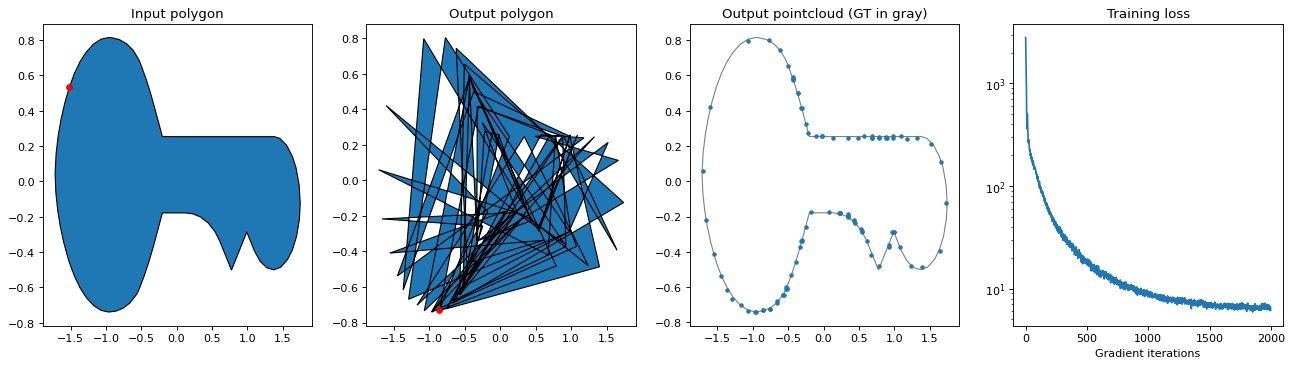

In [13]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle=True, drop_last=True)
net_simple = AE(num_points=96, bottleneck_width=10).cuda()

#loss_fn = torch.nn.MSELoss()
loss_fn = chamfer_distance # enable this to train with the Chamfer distance

train(train_loader, net_simple, loss_fn, num_training_epochs=2000, key='polygon')

In [14]:
# TODO: Explain the issue with Chamfer here

# Task III: Beyond Chamfer

There seems to be a problem about the order of points that is not captured by Chamfer. In our case, vertices are ordered to form a single polygon, only the start/end point is arbitrary. Implement a new distance metric `start_invariant_MSE` that is inspired by Chamfer but exploits the polygon structure. It should measure the similarity of prediction and label using the MSE between pair of points, be invariant to the start and end position, and in addition avoid fold-overs.

In [15]:
def start_invariant_MSE(pred, label):
    min_loss = None
    
    # TODO TASK III
    # Hint1: you can use the following helper function that shifts/rolls a tensor along the third dimension
    def roll_2(x, n=1):
      return torch.cat((x[:,:,-n:], x[:,:,:-n]),dim=2)

    # Find the rotation which minimizes the distance.
    batch_size, _, n_points = pred.size()
    for i in range(n_points):
        target = roll_2(label, i)
        dist = torch.mean((pred-target)**2, dim=(-1,-2))
        if min_loss is None:
            min_loss = dist
        else:
            min_loss, _ = torch.min(torch.stack((min_loss, dist), dim=-1), dim=-1)

    # Hint2: one for loop should be sufficient. Try to use tensor operations as much as possible
    
    return torch.mean(min_loss)

## Task III-b: Debugging

The output of the loss must not change when the start and end point is changed in either of the polygons while keeping the vertex positions fixed. 	Your `start_invariant_MSE` implementation may not fulfill these requirements or have other bugs. To be sure, construct toy examples with the same points but different starting points. Make it simple enough such that you can compute the result by hand and show proper working. Make sure your toy example and loss works correctly not only with individual polygons but batches of polygons, as required during training.


In [16]:
# TODO: debugging example
net_simple2 = AE(num_points=96, bottleneck_width=10).cuda()

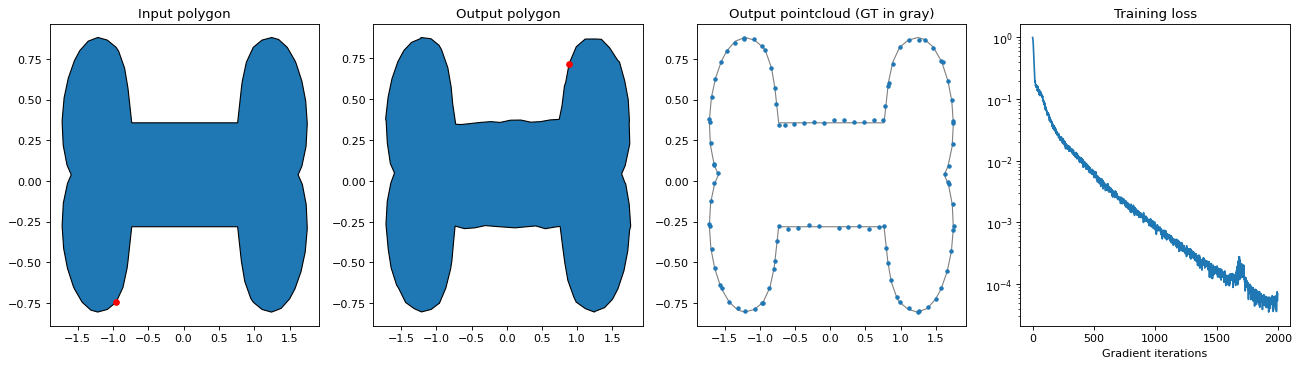

In [17]:
# train net_simple2, with the start_invariant_MSE once you are sure it does the right thing. Compare results visually to the MSE training
net_simple2 = AE(num_points=96, bottleneck_width=10).cuda()
train(train_loader, net_simple2, start_invariant_MSE, num_training_epochs=2000, key='polygon')

# Task IV: Improving the NN architecture

The new training loop below contains data augmentation code that randomizes the start point for every iteration for improving generalization to new shapes. Although the new loss makes the objective invariant, the network remains sensitive to the order of points and does not train well (give it a try). It is your task to improve the provided autoencoder to be invariant to the polygon starting point. Use 1D convolutions (e.g., with kernel size 1 or 3), MaxPooling, ReLU activations, and global pooling to construct the encoder that is free of linear (fully-connected) layers. In particular, 1D convolution with `padding_mode='circular'` 
For us, 6 to 8 convolutional layers and a couple of max-pooling, ReLU, and BatchNorm layers worked, but other architectures are likely to improve. 

Hint: Pay attention to your model complexity. How many parameters does the baseline autoencoder have? How many parameters does your model have.
If your model can't reproduce the training examples, try increasing the number of parameters.


[2] Qi et al. PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation. CVPR 2017.


In [18]:
# circular convolutions are broken in lower PyTorch versions, check that it works for you:
print("pytorch version",torch.__version__)
# convolutions
t = torch.zeros([10,2,8])
c = torch.nn.Conv1d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1, padding_mode='circular')
t = c(t)
print('out shape',t.shape)
# shape should be torch.Size([10, 1, 8]), make sure your pytorch version is >= 1.5.

p = nn.MaxPool1d(kernel_size=2)
t = p(t)
t.shape

pytorch version 1.11.0+cu113
out shape torch.Size([10, 1, 8])


torch.Size([10, 1, 4])

In [19]:
# an improved autoencoder that uses *no* fully-connected layer
class PolygonAE(nn.Module):
    def __init__(self, num_points, bottleneck_width):
        super(PolygonAE, self).__init__()
        channels_decoder = 128
        # TODO, TASK III: Avoid any fully-connected layer in the encoder
        self.encoder = nn.Sequential(
            # TODO create layers in here or after the sequential block

            # Hint: you can use padding_mode='circular' in convolutions
            torch.nn.Conv1d(in_channels=2, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='circular'),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=3),
            torch.nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='circular'),
            nn.ReLU(True),
            torch.nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='circular'),
            nn.ReLU(True),
            nn.BatchNorm1d(32),
            torch.nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='circular'),
            nn.ReLU(True),
            torch.nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1, padding_mode='circular'),
            nn.ReLU(True),
            nn.BatchNorm1d(8),
            torch.nn.Conv1d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1, padding_mode='circular'),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=3),
        )

        # It is OK to maintain the following decoder
        self.fc2a = nn.Linear(bottleneck_width, channels_decoder)
        self.fc2c = nn.Linear(channels_decoder, 2*num_points)

    def encode(self, dictionary):
        x_NCW = dictionary['polygon']
        output = self.encoder(x_NCW)
        return output

    def decode(self, z):
        batch_size = z.shape[0]
        h2 = nn.ReLU()(self.fc2a(z))
        h2 = self.fc2c(h2)    
        y_NCW = h2.view([batch_size,2,-1])
        return {'polygon': y_NCW}

    def forward(self, dictionary):
        z = self.encode(dictionary)        
        out_dict = self.decode(z)
        return out_dict


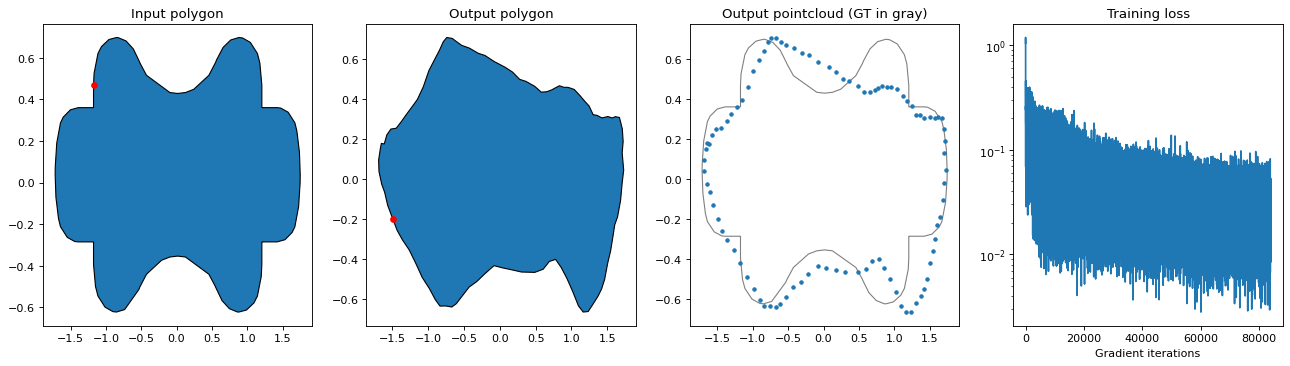

In [28]:
# train a new network to be able to compare results to the initial training
#net_graph = AE(num_points=96, bottleneck_width=10).cuda() # TODO: try this one first
net_graph = PolygonAE(num_points=96, bottleneck_width=10).cuda() # TODO: uncomment this to replace the simlpe AE with your dedicated one
train(train_loader, net_graph, start_invariant_MSE, num_training_epochs=2000, key='polygon', augmentation=True)
# train(train_loader, net_graph, chamfer_distance, num_training_epochs=2000, key='polygon', augmentation=True)

# Task V: Shape space interpolation

The representation learned by autoencoders is well-suited for interpolating within the manifold of feasible shapes, a so-called `shape space`. It is your task to test different ways of interpolating between two vector icons. 

 * Interpolate two point clouds $M_1$ and $M_2$ from the training dataloader, i.e., $M_\text{out} = \lambda M_1 + (1-\lambda) M_2$. Display the outcome for $\lambda \in (0,0.2, \dots, 1)$. 
 * Apply your encoder from task IV on $M_1$ and $M_2$ and save the corresponding latent codes $h_1$ and $h_2$. Interpolate these latent codes and reconstruct them using the decoder. Plot these as before. Try a few different icon pairs and describe and explain the difference between interpolating points and interpolating in the shape space. Do you see issues? Could a VAE overcome these problems? Try a couple of different input examples and explain your observations.

In [29]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 1, shuffle=True, drop_last=True)

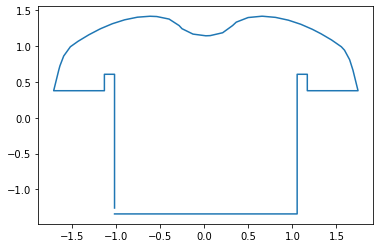

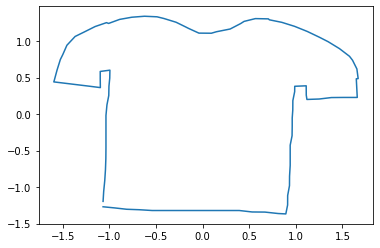

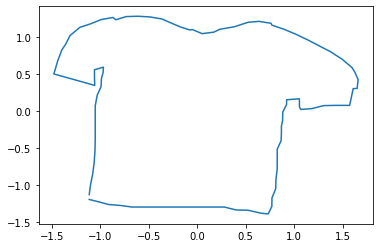

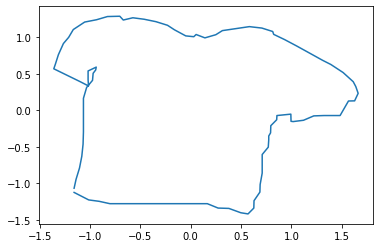

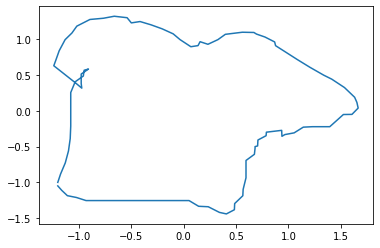

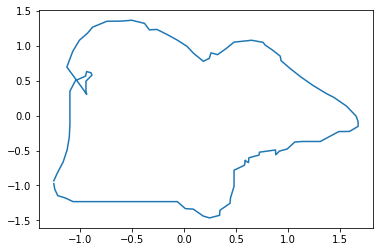

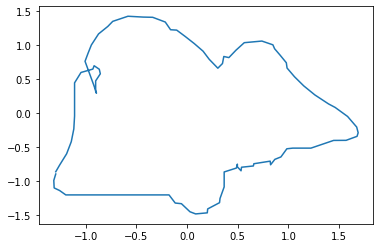

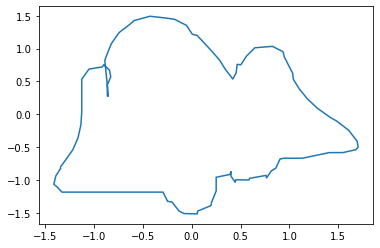

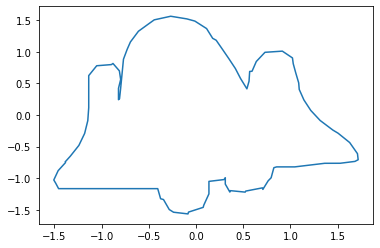

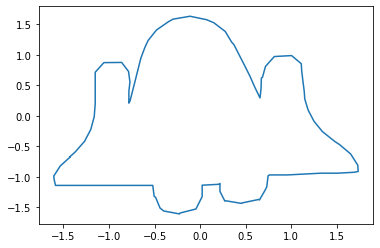

In [30]:
net = net_graph
net.eval()
data_iterator = iter(train_loader)
# data_iterator = iter(val_loader) # doesn't give good results, training set too small
batch_cpu1 = next(data_iterator)
M1 = dict_to_device(batch_cpu1, device)
batch_cpu2 = next(data_iterator)
M2 = dict_to_device(batch_cpu2, device)
for i in range(10):
  lambda_1 = i/10
  M_out = M1['polygon']
  M_out = lambda_1*M1['polygon'] + (1-lambda_1)*M2['polygon']
  plt.plot(*M_out[0].cpu().numpy())
  plt.show()
  
# TODO implement task V

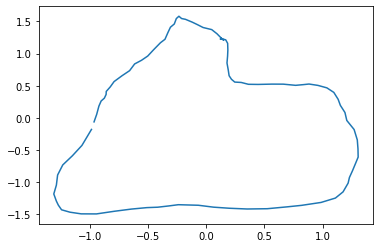

----------


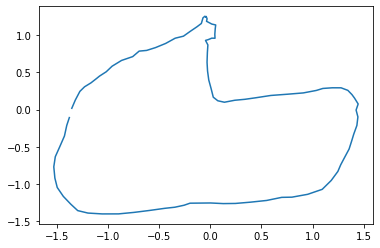

----------


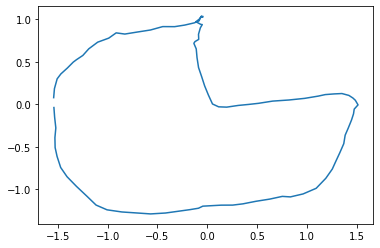

----------


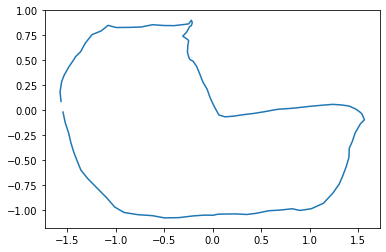

----------


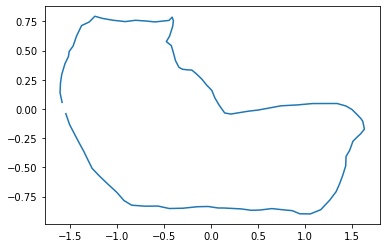

----------


In [31]:
# train a new network to be able to compare results to the initial training
net = net_graph
net.eval()
data_iterator = iter(train_loader)
# data_iterator = iter(val_loader) # doesn't give good results, training set too small
batch_cpu1 = next(data_iterator)
M1 = dict_to_device(batch_cpu1, device)
batch_cpu2 = next(data_iterator)
M2 = dict_to_device(batch_cpu2, device)

for i in range(5):
  lambda_1 = i/10
  h1 = net.encode(M1)
  h2 = net.encode(M2)
  h_out = lambda_1*h1 + (1-lambda_1)*h2
  r_out = net.decode(h_out)['polygon']
  plt.plot(*r_out[0].detach().cpu().numpy())
  plt.show()
  print("----------")
